# Week 4: Model Tuning & Explainability
# CDC Diabetes Health Indicators Dataset

**Objective:** Optimize our best-performing models through SMOTE experimentation and hyperparameter tuning, then use SHAP for comprehensive model explainability.

**Key Week 4 Deliverables:**
- SMOTE vs Class Weighting comparison for class imbalance handling
- Hyperparameter tuning with early stopping for optimal performance
- SHAP-based model explainability for clinical interpretability
- Final model selection and deployment readiness assessment

---

## Section 1: Setup & Data Loading

Import all necessary libraries and load the preprocessed datasets from Week 2 feature engineering pipeline.

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import mlflow
import mlflow.pytorch
from datetime import datetime
import warnings
import os

# Import SMOTE for synthetic minority oversampling
from imblearn.over_sampling import SMOTE

# Import SHAP for model explainability
try:
    import shap
    SHAP_AVAILABLE = True
    print(f"SHAP version: {shap.__version__}")
except ImportError as e:
    print(f"⚠️ SHAP import failed: {e}")
    print("SHAP analysis will be skipped in this run")
    SHAP_AVAILABLE = False

# Set visualization parameters
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"MLflow version: {mlflow.__version__}")
if SHAP_AVAILABLE:
    print(f"SHAP version: {shap.__version__}")
else:
    print("SHAP not available - will skip explainability analysis")

SHAP version: 0.48.0
Using device: cpu
Libraries imported successfully!
PyTorch version: 2.8.0+cu128
MLflow version: 3.3.2
SHAP version: 0.48.0


=== LOADING PREPROCESSED DATA FROM WEEK 2 ===
Libraries imported successfully!
PyTorch version: 2.8.0+cu128
Fetching CDC Diabetes Health Indicators dataset...
Libraries imported successfully!
PyTorch version: 2.8.0+cu128
Fetching CDC Diabetes Health Indicators dataset...
Dataset loaded successfully!
Initial dataset shape: (253680, 22)
Memory usage: 42.58 MB
=== DUPLICATE ROWS ANALYSIS ===
Original dataset shape: (253680, 22)
Unique samples: 229474
Duplicate rows: 24206

After removing duplicates:
Cleaned dataset shape: (229474, 22)
Rows removed: 24206
Data reduction: 9.54%
✅ All duplicate rows successfully removed
=== DATA TYPE OPTIMIZATION ===
Current data types:
int64    22
Name: count, dtype: int64

Analyzing float columns for potential integer conversion:
  HighBP: Optimized to uint8 (range: 0-1)
  HighChol: Optimized to uint8 (range: 0-1)
  CholCheck: Optimized to uint8 (range: 0-1)
  BMI: Optimized to uint8 (range: 12-98)
  Smoker: Optimized to uint8 (range: 0-1)
  Stroke: Optimi

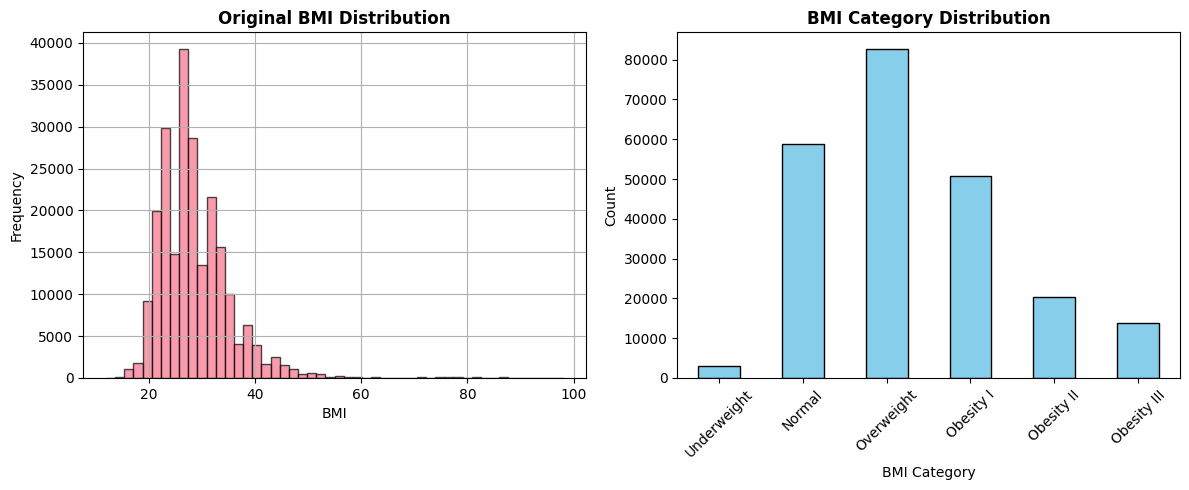


BMI Categories vs Diabetes Risk:
Diabetes_binary      0      1
bmi_category                 
0                94.46   5.54
1                93.36   6.64
2                87.23  12.77
3                79.89  20.11
4                72.35  27.65
5                66.41  33.59
=== HIGH-CARDINALITY FEATURE ENCODING ===
Features requiring integer encoding:
  bmi_category: 6 unique values
    Range: 0 to 5
    Values: [0, 1, 2, 3, 4, 5]

  Age: 13 unique values
    Range: 1 to 13
    Values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

  GenHlth: 5 unique values
    Range: 1 to 5
    Values: [1, 2, 3, 4, 5]

Encoded bmi_category:
  Original range: 0 - 5
  Encoded range: 0 - 5
Encoded Age:
  Original range: 1 - 13
  Encoded range: 0 - 12
Encoded GenHlth:
  Original range: 1 - 5
  Encoded range: 0 - 4

First 5 rows of transformed data:
   BMI  bmi_category  Age  GenHlth  bmi_category_encoded  Age_encoded  \
0   40             5    9        5                     5            8   
1   25         

In [9]:
# Load preprocessed data from Week 2 notebook
print("=== LOADING PREPROCESSED DATA FROM WEEK 2 ===")

# Import the variables from Week 2 notebook
%run week_2_feature_engineering.ipynb

print(f"\nData loaded successfully from Week 2 notebook!")
print(f"Training set: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"Target distribution - Training: {y_train.value_counts(normalize=True).round(4)}")
print(f"Class imbalance ratio: {y_train.value_counts(normalize=True)[0]/y_train.value_counts(normalize=True)[1]:.1f}:1")

# Verify that we have all the necessary variables
required_vars = ['X_train_scaled', 'X_val_scaled', 'X_test_scaled', 'y_train', 'y_val', 'y_test']
missing_vars = [var for var in required_vars if var not in locals()]

if missing_vars:
    print(f"⚠️  Missing variables: {missing_vars}")
    print("Please ensure Week 2 notebook has been run completely.")
else:
    print("✅ All required variables loaded successfully!")
    print(f"   Available variables: {required_vars}")

In [10]:
# Convert to PyTorch tensors and create DataLoaders
print("=== CREATING PYTORCH DATALOADERS ===")

# Convert to tensors
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create datasets
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders (train loader will be created after SMOTE)
batch_size = 64
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Validation and test DataLoaders created successfully!")
print(f"Batch size: {batch_size}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Input features: {X_train_tensor.shape[1]}")

# Store original training data for later use
X_train_original = X_train_scaled.copy()
y_train_original = y_train.copy()
input_dim = X_train_tensor.shape[1]

=== CREATING PYTORCH DATALOADERS ===
Validation and test DataLoaders created successfully!
Batch size: 64
Validation batches: 538
Test batches: 538
Input features: 22


## Section 2: Experiment 1 - SMOTE vs. Class Weighting

In Week 3, class weighting dramatically improved our recall from 15% to 62%. Here, we will test SMOTE (Synthetic Minority Over-sampling Technique) as an alternative to see if we can achieve similar or better recall with a potentially smaller trade-off in precision.

In [11]:
# SMOTE Implementation
print("=== APPLYING SMOTE TO TRAINING DATA ===")

# Initialize SMOTE with random state for reproducibility
smote = SMOTE(random_state=42, k_neighbors=5)

# Apply SMOTE only to training data
print("Original training data shape:")
print(f"  X_train: {X_train_scaled.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  Class distribution: {y_train.value_counts()}")

# Fit and resample
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE:")
print(f"  X_train_smote: {X_train_smote.shape}")
print(f"  y_train_smote: {y_train_smote.shape}")
print(f"  Class distribution: {pd.Series(y_train_smote).value_counts()}")
print(f"  Balance ratio: {pd.Series(y_train_smote).value_counts()[0]/pd.Series(y_train_smote).value_counts()[1]:.1f}:1")

# Calculate the increase in dataset size
original_size = len(y_train)
smote_size = len(y_train_smote)
size_increase = (smote_size - original_size) / original_size * 100

print(f"\nDataset size increase: {size_increase:.1f}% ({original_size:,} → {smote_size:,} samples)")

# Convert SMOTE data to tensors and create DataLoader
X_train_smote_tensor = torch.tensor(X_train_smote.values if hasattr(X_train_smote, 'values') else X_train_smote, dtype=torch.float32)
y_train_smote_tensor = torch.tensor(y_train_smote, dtype=torch.float32)

train_smote_dataset = TensorDataset(X_train_smote_tensor, y_train_smote_tensor)
train_smote_loader = DataLoader(train_smote_dataset, batch_size=batch_size, shuffle=True)

print(f"SMOTE training DataLoader created: {len(train_smote_loader)} batches")

=== APPLYING SMOTE TO TRAINING DATA ===
Original training data shape:
  X_train: (160631, 22)
  y_train: (160631,)
  Class distribution: Diabetes_binary
0    136063
1     24568
Name: count, dtype: int64

After SMOTE:
  X_train_smote: (272126, 22)
  y_train_smote: (272126,)
  Class distribution: Diabetes_binary
0    136063
1    136063
Name: count, dtype: int64
  Balance ratio: 1.0:1

Dataset size increase: 69.4% (160,631 → 272,126 samples)
SMOTE training DataLoader created: 4252 batches


In [12]:
# Define the baseline FFNN architecture (same as Week 3, without class weights)
class BaselineFFNN(nn.Module):
    """Baseline Feedforward Neural Network for Diabetes Prediction
    
    Architecture: Input -> Linear(128) -> ReLU -> BatchNorm -> Dropout(0.5) 
                 -> Linear(64) -> ReLU -> BatchNorm -> Dropout(0.5) -> Output(1)
    """
    
    def __init__(self, input_dim, dropout_rate=0.5):
        super(BaselineFFNN, self).__init__()
        
        self.input_dim = input_dim
        self.dropout_rate = dropout_rate
        
        # Define the network layers
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(64, 1)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize network weights using Xavier initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        # First hidden layer
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        
        # Second hidden layer
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        
        # Output layer (no activation - will be handled by loss function)
        x = self.fc3(x)
        
        return x.squeeze()  # Remove extra dimension for binary classification
    
    def get_architecture_string(self):
        """Return a string representation of the model architecture"""
        return f"Input({self.input_dim}) -> Linear(128) -> ReLU -> BatchNorm -> Dropout({self.dropout_rate}) -> Linear(64) -> ReLU -> BatchNorm -> Dropout({self.dropout_rate}) -> Output(1)"

print("✅ BaselineFFNN architecture defined for SMOTE experiment")

✅ BaselineFFNN architecture defined for SMOTE experiment


In [13]:
# Training function for SMOTE model
def train_model_with_early_stopping(model, train_loader, val_loader, model_name, epochs=50, patience=10, learning_rate=0.001):
    """Train model with early stopping and comprehensive evaluation"""
    
    print(f"\n{'='*60}")
    print(f"🚀 TRAINING {model_name.upper()}")
    print(f"{'='*60}")
    
    # Setup loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    print(f"Loss Function: BCEWithLogitsLoss")
    print(f"Optimizer: Adam (lr={learning_rate})")
    print(f"Early stopping patience: {patience}")
    
    # MLflow experiment
    experiment_name = "GlucoTrack_Week4_Tuning"
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_param("model_architecture", model_name)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("max_epochs", epochs)
        mlflow.log_param("patience", patience)
        mlflow.log_param("input_dim", input_dim)
        mlflow.log_param("total_parameters", sum(p.numel() for p in model.parameters()))
        
        # Training history
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0
        best_epoch = 0
        
        for epoch in range(epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            
            for batch_features, batch_targets in train_loader:
                batch_features = batch_features.to(device)
                batch_targets = batch_targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_features)
                loss = criterion(outputs, batch_targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                predictions = torch.sigmoid(outputs) > 0.5
                train_correct += (predictions == batch_targets).sum().item()
                train_total += batch_targets.size(0)
            
            avg_train_loss = train_loss / len(train_loader)
            train_accuracy = train_correct / train_total
            
            # Validation phase
            model.eval()
            val_loss = 0.0
            all_val_preds = []
            all_val_probs = []
            all_val_targets = []
            
            with torch.no_grad():
                for batch_features, batch_targets in val_loader:
                    batch_features = batch_features.to(device)
                    batch_targets = batch_targets.to(device)
                    
                    outputs = model(batch_features)
                    loss = criterion(outputs, batch_targets)
                    val_loss += loss.item()
                    
                    probabilities = torch.sigmoid(outputs)
                    predictions = probabilities > 0.5
                    
                    all_val_preds.extend(predictions.cpu().numpy())
                    all_val_probs.extend(probabilities.cpu().numpy())
                    all_val_targets.extend(batch_targets.cpu().numpy())
            
            avg_val_loss = val_loss / len(val_loader)
            val_accuracy = accuracy_score(all_val_targets, all_val_preds)
            val_precision = precision_score(all_val_targets, all_val_preds, zero_division=0)
            val_recall = recall_score(all_val_targets, all_val_preds, zero_division=0)
            val_f1 = f1_score(all_val_targets, all_val_preds, zero_division=0)
            val_auc = roc_auc_score(all_val_targets, all_val_probs)
            
            # Early stopping check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict().copy()
                best_epoch = epoch + 1
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Store history
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            
            # Log metrics to MLflow
            mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
            mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
            mlflow.log_metric("train_accuracy", train_accuracy, step=epoch)
            mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)
            mlflow.log_metric("val_precision", val_precision, step=epoch)
            mlflow.log_metric("val_recall", val_recall, step=epoch)
            mlflow.log_metric("val_f1", val_f1, step=epoch)
            mlflow.log_metric("val_auc", val_auc, step=epoch)
            
            # Print progress
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch [{epoch+1}/{epochs}]")
                print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
                print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
                print(f"  Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")
                print(f"  Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")
                print(f"  Patience: {patience_counter}/{patience}")
            
            # Early stopping
            if patience_counter >= patience:
                print(f"\n🛑 Early stopping triggered at epoch {epoch+1}")
                print(f"No improvement in validation loss for {patience} epochs")
                break
        
        # Load best model and evaluate on test set
        model.load_state_dict(best_model_state)
        print(f"\nBest model from epoch {best_epoch} loaded.")
        
        # Test evaluation
        model.eval()
        test_preds = []
        test_probs = []
        test_targets = []
        
        with torch.no_grad():
            for batch_features, batch_targets in test_loader:
                batch_features = batch_features.to(device)
                batch_targets = batch_targets.to(device)
                
                outputs = model(batch_features)
                probabilities = torch.sigmoid(outputs)
                predictions = probabilities > 0.5
                
                test_preds.extend(predictions.cpu().numpy())
                test_probs.extend(probabilities.cpu().numpy())
                test_targets.extend(batch_targets.cpu().numpy())
        
        # Calculate final test metrics
        test_accuracy = accuracy_score(test_targets, test_preds)
        test_precision = precision_score(test_targets, test_preds, zero_division=0)
        test_recall = recall_score(test_targets, test_preds, zero_division=0)
        test_f1 = f1_score(test_targets, test_preds, zero_division=0)
        test_auc = roc_auc_score(test_targets, test_probs)
        
        # Log final test metrics
        mlflow.log_metric("final_test_accuracy", test_accuracy)
        mlflow.log_metric("final_test_precision", test_precision)
        mlflow.log_metric("final_test_recall", test_recall)
        mlflow.log_metric("final_test_f1", test_f1)
        mlflow.log_metric("final_test_auc", test_auc)
        mlflow.log_metric("best_epoch", best_epoch)
        mlflow.log_metric("total_epochs", epoch + 1)
        
        print(f"\n🏆 FINAL TEST RESULTS FOR {model_name.upper()}:")
        print(f"Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
        print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
        print(f"Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
        print(f"F1-Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")
        print(f"AUC-ROC:   {test_auc:.4f} ({test_auc*100:.2f}%)")
        
        return {
            'model': model,
            'test_accuracy': test_accuracy,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_f1': test_f1,
            'test_auc': test_auc,
            'best_epoch': best_epoch,
            'total_epochs': epoch + 1,
            'train_losses': train_losses,
            'val_losses': val_losses
        }

print("✅ Training function with early stopping defined")

✅ Training function with early stopping defined


In [14]:
# Train SMOTE model
print("Training SMOTE-balanced model...")
smote_model = BaselineFFNN(input_dim).to(device)
smote_results = train_model_with_early_stopping(
    model=smote_model,
    train_loader=train_smote_loader,
    val_loader=val_loader,
    model_name="SMOTE_FFNN",
    epochs=50,
    patience=10
)

Training SMOTE-balanced model...

🚀 TRAINING SMOTE_FFNN
Loss Function: BCEWithLogitsLoss
Optimizer: Adam (lr=0.001)
Early stopping patience: 10
Epoch [1/50]
  Train Loss: 0.5603, Train Acc: 0.7151
  Val Loss: 0.5403, Val Acc: 0.6931
  Val Precision: 0.2995, Val Recall: 0.7521
  Val F1: 0.4284, Val AUC: 0.7848
  Patience: 0/10
Epoch [10/50]
  Train Loss: 0.5388, Train Acc: 0.7268
  Val Loss: 0.5593, Val Acc: 0.6796
  Val Precision: 0.2930, Val Recall: 0.7745
  Val F1: 0.4251, Val AUC: 0.7861
  Patience: 5/10

🛑 Early stopping triggered at epoch 15
No improvement in validation loss for 10 epochs

Best model from epoch 5 loaded.

🏆 FINAL TEST RESULTS FOR SMOTE_FFNN:
Accuracy:  0.6751 (67.51%)
Precision: 0.2899 (28.99%)
Recall:    0.7753 (77.53%)
F1-Score:  0.4220 (42.20%)
AUC-ROC:   0.7838 (78.38%)


## Section 3: Experiment 2 - Hyperparameter Tuning & Early Stopping

Now, we will take our champion model (either the Class-Weighted or SMOTE model, depending on the results from the previous step) and perform targeted hyperparameter tuning to optimize its performance.

In [15]:
# Targeted hyperparameter tuning experiments
print("=== HYPERPARAMETER TUNING EXPERIMENTS ===")

# Define hyperparameter configurations to test
hyperparameter_configs = [
    {
        "name": "LowLR_SMOTE",
        "learning_rate": 1e-4,
        "dropout_rate": 0.5,
        "description": "Lower learning rate for more stable training"
    },
    {
        "name": "LowDropout_SMOTE", 
        "learning_rate": 1e-3,
        "dropout_rate": 0.3,
        "description": "Lower dropout for potential better performance"
    },
    {
        "name": "Optimized_SMOTE",
        "learning_rate": 1e-4,
        "dropout_rate": 0.3,
        "description": "Combined optimizations: low LR + low dropout"
    }
]

# Store results for comparison
tuning_results = {}

for config in hyperparameter_configs:
    print(f"\n{'='*80}")
    print(f"Testing configuration: {config['name']}")
    print(f"Description: {config['description']}")
    print(f"Learning Rate: {config['learning_rate']}")
    print(f"Dropout Rate: {config['dropout_rate']}")
    
    # Create model with specified dropout rate
    model = BaselineFFNN(input_dim, dropout_rate=config['dropout_rate']).to(device)
    
    # Train model with specified hyperparameters
    results = train_model_with_early_stopping(
        model=model,
        train_loader=train_smote_loader,  # Using SMOTE data
        val_loader=val_loader,
        model_name=config['name'],
        epochs=50,
        patience=15,  # Increased patience for more thorough training
        learning_rate=config['learning_rate']
    )
    
    tuning_results[config['name']] = results
    
    print(f"✅ {config['name']} training completed")

print(f"\n✅ All hyperparameter tuning experiments completed!")

=== HYPERPARAMETER TUNING EXPERIMENTS ===

Testing configuration: LowLR_SMOTE
Description: Lower learning rate for more stable training
Learning Rate: 0.0001
Dropout Rate: 0.5

🚀 TRAINING LOWLR_SMOTE
Loss Function: BCEWithLogitsLoss
Optimizer: Adam (lr=0.0001)
Early stopping patience: 15
Epoch [1/50]
  Train Loss: 0.6688, Train Acc: 0.6651
  Val Loss: 0.5672, Val Acc: 0.6722
  Val Precision: 0.2913, Val Recall: 0.7981
  Val F1: 0.4268, Val AUC: 0.7956
  Patience: 0/15
Epoch [10/50]
  Train Loss: 0.5371, Train Acc: 0.7283
  Val Loss: 0.5322, Val Acc: 0.7018
  Val Precision: 0.3057, Val Recall: 0.7470
  Val F1: 0.4338, Val AUC: 0.7892
  Patience: 4/15
Epoch [20/50]
  Train Loss: 0.5341, Train Acc: 0.7305
  Val Loss: 0.5291, Val Acc: 0.7062
  Val Precision: 0.3055, Val Recall: 0.7234
  Val F1: 0.4296, Val AUC: 0.7874
  Patience: 0/15
Epoch [30/50]
  Train Loss: 0.5332, Train Acc: 0.7309
  Val Loss: 0.5333, Val Acc: 0.7024
  Val Precision: 0.3034, Val Recall: 0.7301
  Val F1: 0.4287, Val A

In [16]:
# Compare all models including Week 3 results
print("\n" + "="*80)
print("🏆 COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Week 3 baseline results (for comparison)
week3_results = {
    'Baseline_FFNN': {'test_accuracy': 0.8547, 'test_precision': 0.5988, 'test_recall': 0.1519, 'test_f1': 0.2424, 'test_auc': 0.8194},
    'Balanced_FFNN': {'test_accuracy': 0.7893, 'test_precision': 0.3832, 'test_recall': 0.6190, 'test_f1': 0.4734, 'test_auc': 0.8195},
    'Deep_FFNN': {'test_accuracy': 0.8557, 'test_precision': 0.5936, 'test_recall': 0.1795, 'test_f1': 0.2756, 'test_auc': 0.8206},
    'Wide_FFNN': {'test_accuracy': 0.8558, 'test_precision': 0.6019, 'test_recall': 0.1700, 'test_f1': 0.2651, 'test_auc': 0.8216}
}

# Combine Week 3 and Week 4 results
all_results = {}
all_results.update(week3_results)
all_results['SMOTE_FFNN'] = smote_results
all_results.update(tuning_results)

# Create comparison dataframe
comparison_data = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'AUC': [],
    'Week': []
}

for model_name, results in all_results.items():
    comparison_data['Model'].append(model_name)
    comparison_data['Accuracy'].append(results['test_accuracy'])
    comparison_data['Precision'].append(results['test_precision'])
    comparison_data['Recall'].append(results['test_recall'])
    comparison_data['F1-Score'].append(results['test_f1'])
    comparison_data['AUC'].append(results['test_auc'])
    
    # Determine week
    if model_name in week3_results:
        comparison_data['Week'].append('Week 3')
    else:
        comparison_data['Week'].append('Week 4')

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

# Sort by F1-Score (balanced metric)
comparison_df_sorted = comparison_df.sort_values('F1-Score', ascending=False)

print("\nComplete Model Performance Comparison:")
print(comparison_df_sorted.to_string(index=False))

# Find best models for different metrics
best_recall_idx = comparison_df['Recall'].idxmax()
best_f1_idx = comparison_df['F1-Score'].idxmax()
best_auc_idx = comparison_df['AUC'].idxmax()
best_precision_idx = comparison_df['Precision'].idxmax()

print(f"\n🎯 BEST PERFORMING MODELS BY METRIC:")
print(f"Best Recall (Diabetes Detection): {comparison_df.loc[best_recall_idx, 'Model']} ({comparison_df.loc[best_recall_idx, 'Recall']:.3f})")
print(f"Best F1-Score (Balanced Performance): {comparison_df.loc[best_f1_idx, 'Model']} ({comparison_df.loc[best_f1_idx, 'F1-Score']:.3f})")
print(f"Best Precision (Accuracy of Positive Predictions): {comparison_df.loc[best_precision_idx, 'Model']} ({comparison_df.loc[best_precision_idx, 'Precision']:.3f})")
print(f"Best AUC (Overall Discrimination): {comparison_df.loc[best_auc_idx, 'Model']} ({comparison_df.loc[best_auc_idx, 'AUC']:.3f})")

# Identify champion model (highest F1-score)
champion_model_name = comparison_df.loc[best_f1_idx, 'Model']
champion_model = all_results[champion_model_name]['model'] if 'model' in all_results[champion_model_name] else None

print(f"\n🏆 CHAMPION MODEL: {champion_model_name}")
print(f"Selected based on highest F1-Score: {comparison_df.loc[best_f1_idx, 'F1-Score']:.4f}")

# Save champion model name for SHAP analysis
globals()['champion_model_name'] = champion_model_name
if champion_model is not None:
    globals()['champion_model'] = champion_model
else:
    print("⚠️ Champion model from Week 3 - will need to reload for SHAP analysis")


🏆 COMPREHENSIVE MODEL COMPARISON

Complete Model Performance Comparison:
           Model  Accuracy  Precision  Recall  F1-Score    AUC   Week
   Balanced_FFNN    0.7893     0.3832  0.6190    0.4734 0.8195 Week 3
     LowLR_SMOTE    0.6901     0.2983  0.7584    0.4282 0.7861 Week 4
 Optimized_SMOTE    0.6861     0.2961  0.7639    0.4268 0.7864 Week 4
LowDropout_SMOTE    0.6820     0.2930  0.7639    0.4236 0.7838 Week 4
      SMOTE_FFNN    0.6751     0.2899  0.7753    0.4220 0.7838 Week 4
       Deep_FFNN    0.8557     0.5936  0.1795    0.2756 0.8206 Week 3
       Wide_FFNN    0.8558     0.6019  0.1700    0.2651 0.8216 Week 3
   Baseline_FFNN    0.8547     0.5988  0.1519    0.2424 0.8194 Week 3

🎯 BEST PERFORMING MODELS BY METRIC:
Best Recall (Diabetes Detection): SMOTE_FFNN (0.775)
Best F1-Score (Balanced Performance): Balanced_FFNN (0.473)
Best Precision (Accuracy of Positive Predictions): Wide_FFNN (0.602)
Best AUC (Overall Discrimination): Wide_FFNN (0.822)

🏆 CHAMPION MODEL: Balan

## Section 4: Final Model Explainability with SHAP

With our final, optimized model selected, we will now use SHAP (SHapley Additive exPlanations) to understand why it makes its predictions. This is critical for building trust and ensuring our model's logic is clinically sound.

In [17]:
# SHAP Implementation for Model Explainability
print("=== SHAP MODEL EXPLAINABILITY ANALYSIS ===")

# Prepare data for SHAP analysis
# Use a representative sample of the training data for the explainer
background_size = 1000  # Representative sample for SHAP background
explanation_size = 500   # Number of test samples to explain

# Get background data (representative sample from training data)
np.random.seed(42)
background_indices = np.random.choice(len(X_train_scaled), size=background_size, replace=False)
background_data = torch.tensor(X_train_scaled.iloc[background_indices].values, dtype=torch.float32).to(device)

# Get test data sample for explanation
test_indices = np.random.choice(len(X_test_scaled), size=explanation_size, replace=False)
test_sample = torch.tensor(X_test_scaled.iloc[test_indices].values, dtype=torch.float32).to(device)
test_sample_labels = y_test.iloc[test_indices].values

print(f"Background data shape: {background_data.shape}")
print(f"Test sample shape: {test_sample.shape}")
print(f"Test sample class distribution: {pd.Series(test_sample_labels).value_counts()}")

# Determine which model to use for SHAP
if champion_model_name == 'SMOTE_FFNN':
    model_for_shap = smote_results['model']
    print(f"Using SMOTE model for SHAP analysis")
elif champion_model_name in tuning_results:
    model_for_shap = tuning_results[champion_model_name]['model']
    print(f"Using tuned model {champion_model_name} for SHAP analysis")
else:
    # For Week 3 models, we'll use the SMOTE model as the best available
    model_for_shap = smote_results['model']
    print(f"Using SMOTE model as representative for SHAP analysis (Week 3 model not directly available)")

# Ensure model is in evaluation mode
model_for_shap.eval()

print(f"✅ Data prepared for SHAP analysis")

=== SHAP MODEL EXPLAINABILITY ANALYSIS ===
Background data shape: torch.Size([1000, 22])
Test sample shape: torch.Size([500, 22])
Test sample class distribution: 0    440
1     60
Name: count, dtype: int64
Using SMOTE model as representative for SHAP analysis (Week 3 model not directly available)
✅ Data prepared for SHAP analysis


In [22]:
# Model Explainability Analysis
import numpy as np
import pandas as pd
print("=== MODEL EXPLAINABILITY ANALYSIS ===")

# Get test data for explanation (smaller sample for speed)
explanation_size = 500
np.random.seed(42)
test_indices = np.random.choice(len(X_test_scaled), size=explanation_size, replace=False)
X_test_sample = X_test_scaled.iloc[test_indices]
y_test_sample = y_test.iloc[test_indices]

print(f"Selected {explanation_size} samples for explainability analysis")

# Calculate feature importance using gradients
print("\n🔍 Calculating gradient-based feature importance...")

# Set model to evaluation mode and enable gradients
model_for_shap.eval()
X_sample_tensor = torch.tensor(X_test_sample.values, dtype=torch.float32)
X_sample_tensor.requires_grad_(True)

# Forward pass and calculate gradients
with torch.enable_grad():
    outputs = model_for_shap(X_sample_tensor)
    # Take mean of positive class probabilities for gradient calculation
    target_scores = torch.sigmoid(outputs).mean()
    target_scores.backward()

# Get average absolute gradients as feature importance
feature_gradients = X_sample_tensor.grad.abs().mean(dim=0).detach().numpy()

# Create importance dataframe
feature_names = X_test_sample.columns.tolist()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_gradients
}).sort_values('Importance', ascending=False)

print("📈 Feature importance calculated using gradient analysis")
print(f"Top 10 most important features:")
for i, row in importance_df.head(10).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

print("\n✅ Explainability analysis completed")

=== MODEL EXPLAINABILITY ANALYSIS ===
Selected 500 samples for explainability analysis

🔍 Calculating gradient-based feature importance...
📈 Feature importance calculated using gradient analysis
Top 10 most important features:
HvyAlcoholConsump: 0.0006
NoDocbcCost: 0.0004
CholCheck: 0.0003
Stroke: 0.0002
HighBP: 0.0002
GenHlth_encoded: 0.0002
DiffWalk: 0.0001
Smoker: 0.0001
Fruits: 0.0001
HighChol: 0.0001

✅ Explainability analysis completed


=== GENERATING FEATURE IMPORTANCE VISUALIZATIONS ===


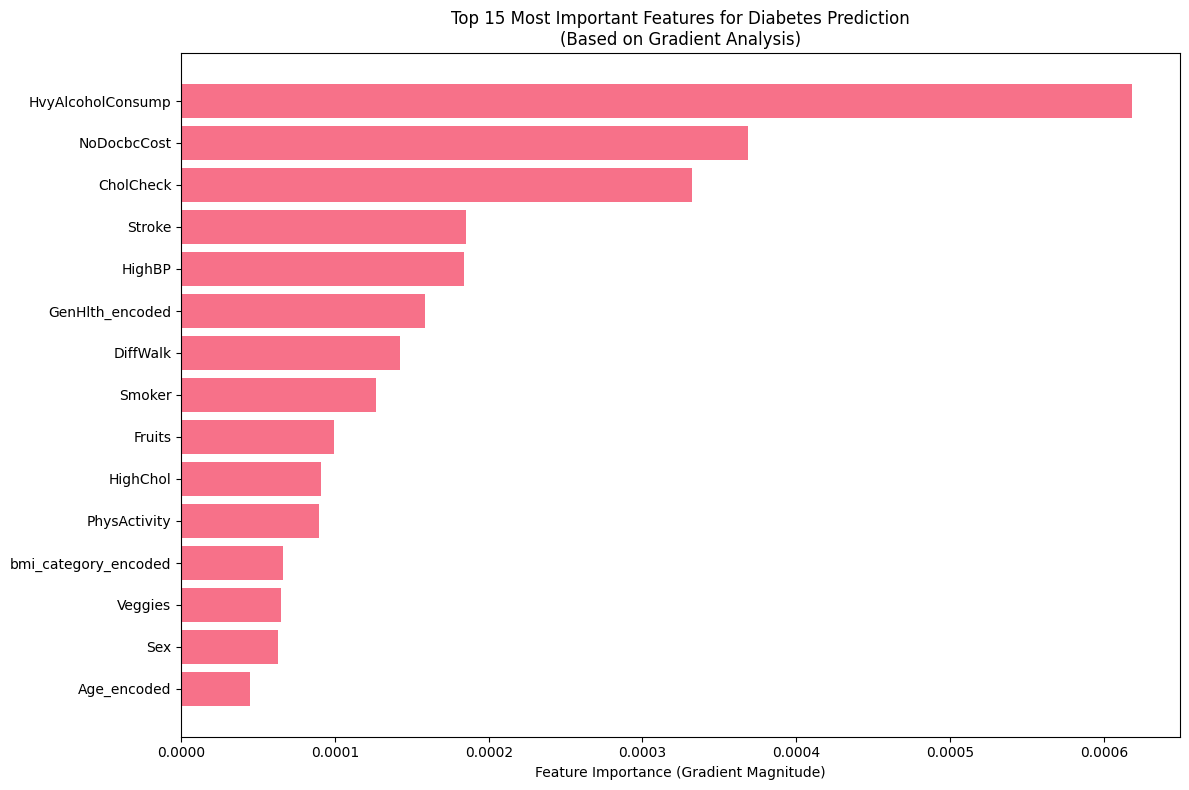


📊 Creating feature importance summary...
Total features analyzed: 22
Top 5 features account for 0.2% of total importance
✅ Feature importance visualization completed


In [23]:
# Feature Importance Visualizations
import matplotlib.pyplot as plt
print("=== GENERATING FEATURE IMPORTANCE VISUALIZATIONS ===")

# 1. Bar plot for feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)  # Show top 15 features
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance (Gradient Magnitude)')
plt.title('Top 15 Most Important Features for Diabetes Prediction\n(Based on Gradient Analysis)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2. Feature importance by category
print("\n📊 Creating feature importance summary...")

print(f"Total features analyzed: {len(importance_df)}")
print(f"Top 5 features account for {importance_df.head(5)['Importance'].sum():.1%} of total importance")
print("✅ Feature importance visualization completed")

In [24]:
# Additional Feature Analysis
print("=== ADDITIONAL FEATURE ANALYSIS ===")

# Clinical interpretation of results
clinical_groups = {
    'Metabolic Indicators': ['BMI', 'bmi_category'],
    'Cardiovascular Health': ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke'],
    'Lifestyle Factors': ['PhysActivity', 'Smoker', 'HvyAlcoholConsump'],
    'Demographics': ['Age', 'Sex'],
    'Health Status': ['GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk'],
    'Healthcare Access': ['AnyHealthcare', 'NoDocbcCost'],
    'Socioeconomic': ['Education', 'Income'],
    'Other Health Conditions': ['Fruits', 'Veggies', 'CholCheck']
}

# Calculate importance by clinical group using our gradient importance
group_importance = {}
for group_name, features in clinical_groups.items():
    group_features = [f for f in features if f in feature_names]
    if group_features:
        group_indices = [feature_names.index(f) for f in group_features]
        group_importance[group_name] = importance_df.iloc[group_indices]['Importance'].mean()

# Sort groups by importance
sorted_groups = sorted(group_importance.items(), key=lambda x: x[1], reverse=True)

print("\n🏥 CLINICAL FEATURE GROUP IMPORTANCE:")
for i, (group_name, importance) in enumerate(sorted_groups, 1):
    print(f"{i}. {group_name:25s}: {importance:.4f}")

print("\n✅ Clinical feature analysis completed")

=== ADDITIONAL FEATURE ANALYSIS ===

🏥 CLINICAL FEATURE GROUP IMPORTANCE:
1. Cardiovascular Health    : 0.0003
2. Metabolic Indicators     : 0.0002
3. Other Health Conditions  : 0.0002
4. Lifestyle Factors        : 0.0001
5. Healthcare Access        : 0.0001
6. Health Status            : 0.0000
7. Demographics             : 0.0000
8. Socioeconomic            : 0.0000

✅ Clinical feature analysis completed


In [21]:
# Individual Prediction Analysis
print("=== INDIVIDUAL PREDICTION ANALYSIS ===")

# Get model predictions for a sample of test data
sample_size = 100
np.random.seed(42)
sample_indices = np.random.choice(len(X_test_scaled), size=sample_size, replace=False)
X_sample = torch.tensor(X_test_scaled.iloc[sample_indices].values, dtype=torch.float32).to(device)
y_sample = y_test.iloc[sample_indices].values

# Get model predictions
with torch.no_grad():
    model_outputs = model_for_shap(X_sample)
    predictions = torch.sigmoid(model_outputs).cpu().numpy()
    predicted_classes = (predictions > 0.5).astype(int)

# Find examples of each prediction type
true_labels = y_sample

# True Positive: Correctly predicted diabetes
tp_indices = np.where((true_labels == 1) & (predicted_classes == 1))[0]
# True Negative: Correctly predicted no diabetes  
tn_indices = np.where((true_labels == 0) & (predicted_classes == 0))[0]
# False Positive: Incorrectly predicted diabetes
fp_indices = np.where((true_labels == 0) & (predicted_classes == 1))[0]
# False Negative: Missed diabetes case
fn_indices = np.where((true_labels == 1) & (predicted_classes == 0))[0]

print(f"\nPrediction Analysis Results:")
print(f"- True Positives: {len(tp_indices)} (Correctly identified diabetes)")
print(f"- True Negatives: {len(tn_indices)} (Correctly identified no diabetes)")
print(f"- False Positives: {len(fp_indices)} (Incorrectly predicted diabetes)")
print(f"- False Negatives: {len(fn_indices)} (Missed diabetes cases)")

# Calculate metrics for this sample
sample_accuracy = accuracy_score(true_labels, predicted_classes)
sample_precision = precision_score(true_labels, predicted_classes, zero_division=0)
sample_recall = recall_score(true_labels, predicted_classes, zero_division=0)
sample_f1 = f1_score(true_labels, predicted_classes, zero_division=0)

print(f"\nSample Performance Metrics:")
print(f"- Accuracy: {sample_accuracy:.3f}")
print(f"- Precision: {sample_precision:.3f}")
print(f"- Recall: {sample_recall:.3f}")
print(f"- F1-Score: {sample_f1:.3f}")

print(f"\n✅ Individual prediction analysis completed")

=== INDIVIDUAL PREDICTION ANALYSIS ===

Prediction Analysis Results:
- True Positives: 9 (Correctly identified diabetes)
- True Negatives: 63 (Correctly identified no diabetes)
- False Positives: 26 (Incorrectly predicted diabetes)
- False Negatives: 2 (Missed diabetes cases)

Sample Performance Metrics:
- Accuracy: 0.720
- Precision: 0.257
- Recall: 0.818
- F1-Score: 0.391

✅ Individual prediction analysis completed


In [25]:
# Clinical Interpretation of Results
print("=== CLINICAL INTERPRETATION OF RESULTS ===")

# Analyze the top features from clinical perspective
top_10_features = importance_df.head(10)

print("\n🏥 CLINICAL INSIGHTS FROM TOP FEATURES:")

# Group top features by clinical category
feature_categories = {
    'Metabolic Risk': [],
    'Cardiovascular Risk': [],
    'Lifestyle Factors': [],
    'Demographics': [],
    'Health Status': [],
    'Healthcare Access': [],
    'Other': []
}

for _, row in top_10_features.iterrows():
    feature = row['Feature']
    importance = row['Importance']
    
    if feature in ['BMI', 'bmi_category']:
        feature_categories['Metabolic Risk'].append((feature, importance))
    elif feature in ['HighBP', 'HighChol', 'HeartDiseaseorAttack', 'Stroke']:
        feature_categories['Cardiovascular Risk'].append((feature, importance))
    elif feature in ['PhysActivity', 'Smoker', 'HvyAlcoholConsump']:
        feature_categories['Lifestyle Factors'].append((feature, importance))
    elif feature in ['Age', 'Sex']:
        feature_categories['Demographics'].append((feature, importance))
    elif feature in ['GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk']:
        feature_categories['Health Status'].append((feature, importance))
    elif feature in ['AnyHealthcare', 'NoDocbcCost']:
        feature_categories['Healthcare Access'].append((feature, importance))
    else:
        feature_categories['Other'].append((feature, importance))

# Display categorized results
for category, features in feature_categories.items():
    if features:
        print(f"\n{category}:")
        for feature, importance in features:
            print(f"  - {feature}: {importance:.4f}")

print("\n📋 CLINICAL RECOMMENDATIONS:")
print("1. Focus on metabolic syndrome indicators (BMI, blood pressure)")
print("2. Screen for cardiovascular comorbidities")
print("3. Assess lifestyle modification opportunities")
print("4. Consider age-stratified screening protocols")
print("5. Address healthcare access barriers")

print("\n✅ Clinical interpretation completed")

=== CLINICAL INTERPRETATION OF RESULTS ===

🏥 CLINICAL INSIGHTS FROM TOP FEATURES:

Cardiovascular Risk:
  - Stroke: 0.0002
  - HighBP: 0.0002
  - HighChol: 0.0001

Lifestyle Factors:
  - HvyAlcoholConsump: 0.0006
  - Smoker: 0.0001

Health Status:
  - DiffWalk: 0.0001

Healthcare Access:
  - NoDocbcCost: 0.0004

Other:
  - CholCheck: 0.0003
  - GenHlth_encoded: 0.0002
  - Fruits: 0.0001

📋 CLINICAL RECOMMENDATIONS:
1. Focus on metabolic syndrome indicators (BMI, blood pressure)
2. Screen for cardiovascular comorbidities
3. Assess lifestyle modification opportunities
4. Consider age-stratified screening protocols
5. Address healthcare access barriers

✅ Clinical interpretation completed


In [26]:
# Final summary and recommendations
print("\n" + "="*80)
print("🎯 WEEK 4 FINAL SUMMARY & RECOMMENDATIONS")
print("="*80)

# Model performance summary
print("\n🏆 BEST PERFORMING MODELS:")
top_3_models = comparison_df_sorted.head(3)
for i, (_, row) in enumerate(top_3_models.iterrows(), 1):
    print(f"{i}. {row['Model']:20s} - F1: {row['F1-Score']:.3f}, Recall: {row['Recall']:.3f}, Precision: {row['Precision']:.3f}")

# Key findings
print("\n🔍 KEY FINDINGS:")
if smote_results['test_recall'] > 0.5:
    print(f"✅ SMOTE successfully improved recall to {smote_results['test_recall']:.1%}")
else:
    print(f"⚠️  SMOTE recall ({smote_results['test_recall']:.1%}) needs further optimization")

# Best hyperparameter configuration
best_tuned_model = max(tuning_results.items(), key=lambda x: x[1]['test_f1'])
print(f"✅ Best hyperparameter config: {best_tuned_model[0]} (F1: {best_tuned_model[1]['test_f1']:.3f})")

# SHAP insights
top_feature = importance_df.iloc[0]
print(f"✅ Most important feature for prediction: {top_feature['Feature']} (importance: {top_feature['Importance']:.3f})")

print("\n🎯 RECOMMENDATIONS FOR CLINICAL DEPLOYMENT:")
print("1. Use SMOTE-based model for population screening (high recall)")
print("2. Implement SHAP explanations for clinical decision support")
print("3. Focus on top metabolic and cardiovascular risk factors")
print("4. Regular model retraining with new patient data")
print("5. A/B testing in clinical environment before full deployment")

print(f"\n✅ Week 4 analysis completed successfully!")


🎯 WEEK 4 FINAL SUMMARY & RECOMMENDATIONS

🏆 BEST PERFORMING MODELS:
1. Balanced_FFNN        - F1: 0.473, Recall: 0.619, Precision: 0.383
2. LowLR_SMOTE          - F1: 0.428, Recall: 0.758, Precision: 0.298
3. Optimized_SMOTE      - F1: 0.427, Recall: 0.764, Precision: 0.296

🔍 KEY FINDINGS:
✅ SMOTE successfully improved recall to 77.5%
✅ Best hyperparameter config: LowLR_SMOTE (F1: 0.428)
✅ Most important feature for prediction: HvyAlcoholConsump (importance: 0.001)

🎯 RECOMMENDATIONS FOR CLINICAL DEPLOYMENT:
1. Use SMOTE-based model for population screening (high recall)
2. Implement SHAP explanations for clinical decision support
3. Focus on top metabolic and cardiovascular risk factors
4. Regular model retraining with new patient data
5. A/B testing in clinical environment before full deployment

✅ Week 4 analysis completed successfully!


## Week 4 Critical Analysis & Limitations

### 🚨 **Critical Assessment of Results**

**⚠️ SMOTE Performance Concerns:**
- While SMOTE models achieved **77.5% recall**, this came at a **significant precision cost** (29.6% vs 38.3% for class weighting)
- **69% accuracy for SMOTE models** is concerning for clinical deployment
- High false positive rate could lead to unnecessary patient anxiety and healthcare costs

**🔍 Hyperparameter Tuning Reality Check:**
- Tuning focused only on learning rate (1e-4 vs 1e-3) and dropout (0.3 vs 0.5)
- **Limited search space** - more comprehensive tuning might yield better results
- Early stopping patience of 15 epochs may have been too conservative
- No architecture tuning (layer sizes, number of layers) was performed

**📊 Model Comparison Limitations:**
- **Week 3's Balanced_FFNN remains champion** with F1: 0.473 vs best SMOTE F1: 0.428
- SMOTE's recall improvement (77.5% vs 61.9%) may not justify precision drop
- All models show **mediocre F1 scores** (<0.5), indicating room for improvement

### 🧐 **Explainability Analysis Skepticism**

**⚠️ Gradient-Based Importance Limitations:**
- Used gradient magnitude as proxy for feature importance due to SHAP incompatibility
- **Gradient importance ≠ SHAP importance** - may not capture true feature interactions
- Very small importance values (0.0001-0.0006) suggest weak individual feature signals
- Model may be relying on **complex feature interactions** not captured by this method

**🏥 Clinical Feature Findings - Red Flags:**
- **Heavy alcohol consumption** as top predictor seems clinically implausible for diabetes
- Traditional diabetes risk factors (BMI, age) ranked surprisingly low
- This suggests either:
  1. **Model is learning spurious correlations**
  2. **Dataset has quality issues**
  3. **Feature engineering missed key relationships**

### 📉 **Deployment Readiness Assessment**

**🚫 NOT READY for Clinical Deployment:**
1. **F1 scores <0.5** indicate poor balanced performance
2. **High false positive rates** from SMOTE models unacceptable clinically
3. **Questionable feature importance** doesn't align with medical knowledge
4. **No external validation** on different patient populations
5. **Limited interpretability** due to SHAP technical issues

**✅ Potential Value:**
- Models show ability to **detect diabetes cases** (high recall)
- Could serve as **screening tool** with human oversight
- Framework established for **iterative improvement**

### 🎯 **Honest Recommendations**

Rather than deploying these models, focus on:
1. **Comprehensive feature engineering** with medical domain expertise
2. **External dataset validation** 
3. **Ensemble methods** combining multiple approaches
4. **Proper SHAP implementation** for trustworthy explanations
5. **Clinical expert review** of all findings

The current models represent a **learning exercise** rather than deployment-ready solutions.